In [1]:
import pandas as pd
from river import (
    preprocessing,
    cluster,
    evaluate,
    stream,
    metrics
)
import os
import sys
sys.path.append('../')
from vibrodiagnostics import selection, models
from sklearn import metrics as skmetrics


PATH_PREFIX = '../../datasets/'
FEATURES_PATH =  os.path.join(PATH_PREFIX, 'features_data')

DATASET_PATH = os.path.join(PATH_PREFIX, 'MAFAULDA.zip')
MAFAULDA_METADATA = os.path.join(FEATURES_PATH, 'mafaulda_metadata.csv')

TD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_FEATURES_PATH)
FD_FEATURES = os.path.join(FEATURES_PATH, selection.FREQ_FEATURES_PATH)
TD_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_AND_FREQ_FEATURES_PATH)

TSFEL_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_FEATURES_PATH)
TSFEL_TD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_TIME_FEATURES_PATH)
TSFEL_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_FREQ_FEATURES_PATH)
TSFEL_SD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_STAT_FEATURES_PATH)

<Axes: xlabel='Observation', ylabel='Silhouette score'>

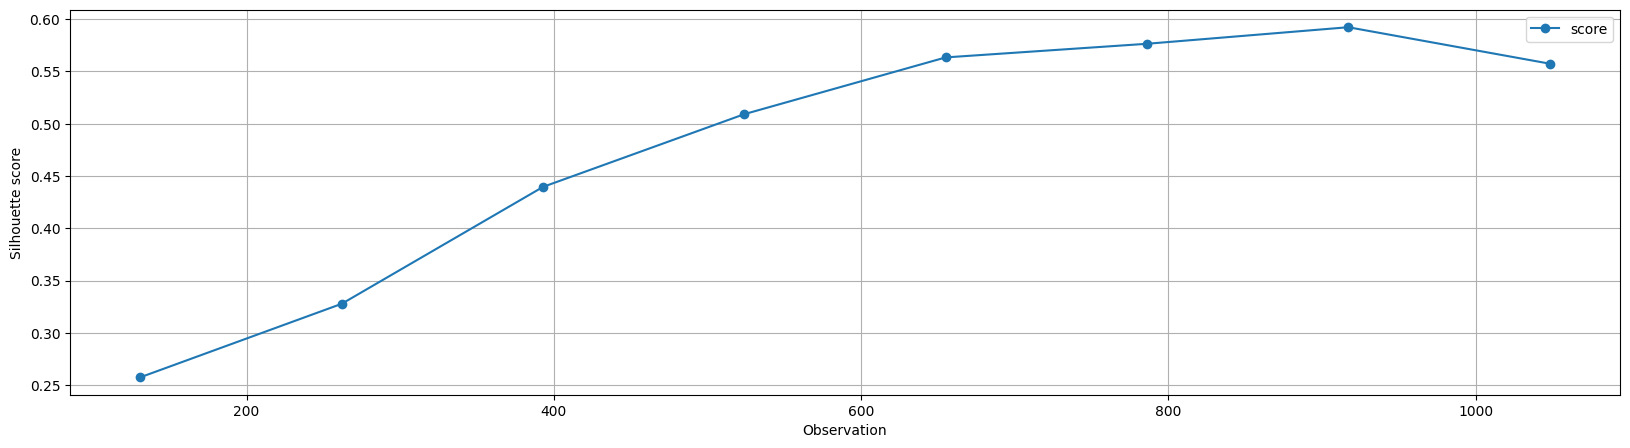

In [21]:
X, y, _, _ = models.features_subset_online(FD_FEATURES, selection.FAULT_CLASSES, ['az'], 'fault') # Other axis separately have low scores

denstream = (
    preprocessing.StandardScaler() | 
    cluster.DenStream(
        decaying_factor=0.01, beta=0.5, mu=2.5, epsilon=0.5, n_samples_init=10
    )
)
step = len(X) // 8

labels = []
scores = []

for i, m in enumerate(stream.iter_pandas(X, y)):
    x, y = m
    y_predict = denstream.predict_one(x)
    labels.append(y_predict)
    if i > 0 and i % step == 0:
        s = skmetrics.silhouette_score(X.iloc[:i+1], labels, metric='euclidean')
        scores.append({'step': i, 'score': s})

    denstream.learn_one(x)


success = pd.DataFrame.from_records(scores).set_index('step')
success.plot(grid=True, figsize=(20, 5), marker='o', ylabel='Silhouette score', xlabel='Observation')

In [ ]:
X, y = models.features_subset(TSFEL_FEATURES, selection.FAULT_CLASSES, ['az'], 'fault')
denstream = (
    preprocessing.MinMaxScaler() |
    cluster.DenStream(
        decaying_factor=0.01, beta=0.5, mu=2.5, epsilon=0.5, n_samples_init=10
    )
)

predictions = []
for x, y in stream.iter_pandas(X, y):
    y_predict = denstream.predict_one(x)
    denstream.learn_one(x)              # denstream = denstream.learn_one(x)
    predictions.append({'y_true': y, 'y_predict': y_predict})


pd.DataFrame.from_records(predictions)